In [1]:

import sys
path='/home/tomas/Ulmer-Berechnung/alps2qutipplus-april/alps2qutipplus-main/'

sys.path.insert(1, path) 

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import qutip as qutip
import scipy.linalg as linalg
import time
from multiprocessing import Pool
from itertools import product
from typing import Optional

import alpsqutip.parallelized_functions_and_workers as plME

from alpsqutip import (build_system, list_models_in_alps_xml,
                       list_geometries_in_alps_xml, graph_from_alps_xml,
                       model_from_alps_xml,
                       restricted_maxent_toolkit as me)

from alpsqutip.operators.states.utils import safe_exp_and_normalize ## function used to safely and robustly map K-states to states

from alpsqutip.scalarprod import fetch_covar_scalar_product
from alpsqutip.operators.states.gibbs import GibbsDensityOperator, GibbsProductDensityOperator

In [3]:

from alpsqutip.operators.arithmetic import (
    ScalarOperator,
    LocalOperator,
    OneBodyOperator,
    Operator,
    ProductOperator,
    ScalarOperator,
    SumOperator,
    QutipOperator
)

from alpsqutip.operators.simplify import simplify_sum_operator

In [4]:
params={}

params['size']=5
params['Jx']=1.; params['Jy'] = .75*params['Jx']; params['Jz']=1.05*params['Jx']

from scipy.optimize import root, fsolve
Ffactor=np.real(max(np.roots(np.poly1d([1, 0, -(params['Jx']*params['Jy']+params['Jx']*params['Jy']+params['Jy']*params['Jz']), 
                           -2*params['Jx']*params['Jy']*params['Jz']]))))
chi_y=fsolve(lambda x,y: x*np.arcsinh(x)-np.sqrt(x**2+1)-y, 1e-1, args=(0))[0]
vLR=4*Ffactor*chi_y



In [7]:
system=build_system(geometry_name= "open chain lattice",model_name="spin", 
                    L=params['size'], J=1)

sites=[s for s in system.sites]
sx_ops=[system.site_operator("Sx", '1[' + str(a) + ']') for a in range(len(system.sites))]
sy_ops=[system.site_operator("Sy", '1[' + str(a) + ']') for a in range(len(system.sites))]
sz_ops=[system.site_operator("Sz", '1[' + str(a) + ']') for a in range(len(system.sites))]

idop = [system.site_operator('identity@1[' + str(a) + ']') for a in range(len(system.sites))]
from functools import reduce
idop = reduce(Operator.__mul__, idop)

#Iz = sum(sz_ops)
H_nn = 0  # Proches voisins
H_lr = 0  # Longue portée

from itertools import combinations

for i, j in combinations(range(params['size']), 2):
    r = 1# abs(i - j)
    Jx_ij = params['Jx'] / r**3
    Jy_ij = params['Jy'] / r**3
    Jz_ij = params['Jz'] / r**3

    term = (
        Jx_ij * sx_ops[i] * sx_ops[j]
        + Jy_ij * sy_ops[i] * sy_ops[j]
        + Jz_ij * sz_ops[i] * sz_ops[j]
    )

    if r == 1:
        H_nn += term  # Interaction de voisins immédiats
    else:
        H_lr += term  # Interaction à longue portée
        
H = H_nn + H_lr
H = H.simplify()

loading model spin  over graph open chain lattice


In [6]:
nv = 3
L = params['size']
H_nv_coupling = 0
H_nuclear_dipolar = 0

# Get unit vectors (can be dynamic if using actual positions)
x̂, ŷ, ẑ = 1.0, 0.0, 1.0  # Example: simple orientation, change as needed

# Loop over NV ↔ other qubits
for k in range(L):
    if k == nv:
        continue

    # Operators for NV (site nv) and k
    Sx_A, Sy_A, Sz_A = sx_ops[nv], sy_ops[nv], sz_ops[nv]
    Sx_B, Sy_B, Sz_B = sx_ops[k], sy_ops[k], sz_ops[k]
    Splus_A = Sx_A + 1j * Sy_A
    Sminus_A = Sx_A - 1j * Sy_A
    Splus_B = Sx_B + 1j * Sy_B
    Sminus_B = Sx_B - 1j * Sy_B

    # Coefficients
    F = 1.0  # You can scale this per site if desired
    F0 = F * (1 - 3 * ẑ**2)
    F1 = -0.5 * F * (x̂ - 1j * ŷ) * ẑ
    F2 = -0.25 * F * (x̂**2 - ŷ**2 + 2j * x̂ * ŷ)

    # Hamiltonian terms
    term = (F0 / 4) * (Sz_A * Sz_B - (Splus_A * Sminus_B + Sminus_A * Splus_B))
    term += F1.conjugate() * (Sz_A * Splus_B + Splus_A * Sz_B)
    term += F1 * (Sz_A * Sminus_B + Sminus_A * Sz_B)
    term += F2 * (Splus_A * Splus_B) + F2.conjugate() * (Sminus_A * Sminus_B)

    H_nv_coupling += term

# Loop over all nuclear-nuclear dipolar couplings
for i, j in combinations(range(L), 2):
    if nv in (i, j):
        continue

    I_z_i, I_z_j = sz_ops[i], sz_ops[j]
    I_p_i = sx_ops[i] + 1j * sy_ops[i]
    I_m_i = sx_ops[i] - 1j * sy_ops[i]
    I_p_j = sx_ops[j] + 1j * sy_ops[j]
    I_m_j = sx_ops[j] - 1j * sy_ops[j]

    Fij = 1.0  # uniform dipolar coupling, or use distance scaling
    term = (Fij / 4) * (I_z_i * I_z_j - (I_p_i * I_m_j + I_m_i * I_p_j))
    H_nuclear_dipolar += term

# Total Hamiltonian
H = (H_nv_coupling + H_nuclear_dipolar).simplify()


In [8]:
z = np.random.rand()
z

0.5872668618995046

In [9]:
obs_SzA = sum(sz for sz in sz_ops)
HBB0=[idop]+[sz for sz in sz_ops]

phi0 = np.array([.0] + [-1+np.random.rand() for _ in HBB0[3:]])

K0 = me.k_state_from_phi_basis(phi0, HBB0).simplify()
sigma0 = GibbsProductDensityOperator(K0)
phi0[0] = np.log(sigma0.tr())
K0 = me.k_state_from_phi_basis(phi0, HBB0).simplify()
sigma0 = GibbsProductDensityOperator(K0)

tgt_obs = obs_SzA
[(sigma0 * op).tr().real for op in sz_ops] 

[0.09906517218408167, 0.13404721596740474, 0.16773967142702256, 0.0, 0.0]

In [9]:
(sigma0 * obs_SzA).tr()

0.6438490029748973

In [10]:
## exact dynamics

timespan=np.linspace(.0, 300/vLR,600)
evs_obs_ex=qutip.mesolve(H=H.to_qutip(), rho0=sigma0.to_qutip(), tlist=timespan, e_ops=[tgt_obs.to_qutip()])

In [11]:
simulations={}
tgt_obs = obs_SzA
sp_local = fetch_covar_scalar_product(sigma0)

from scipy.linalg import cho_solve, cho_factor
       
simulations[1] = {
    "parms":{
    "chosen_depth": 5,
    "m0": 3,
    "eps": 1e-3,
    },
  "saved_cut_times_index_ell":[0],
   "no_acts_ell" : [0],
    "local_bound_error_ell":[],
    "spectral_norm_Hij_tensor_ell":[],
    "instantaneous_w_errors":[],
} 

current_simulation = simulations[1]
current_simulation_parms = current_simulation["parms"]
chosen_depth = current_simulation_parms["chosen_depth"]
eps_tol = current_simulation_parms["eps"]
m0 = current_simulation_parms["m0"]

In [12]:
local_bound_error_ell = []
simulations[1]["evs"] = [(sigma0 * tgt_obs).tr()]  # initial observable expectation

sp_local = fetch_covar_scalar_product(sigma=sigma0)
sigma_star = sigma0
local_t_value = 0.0

# Initial bass construction and orthogonalization
HBB_ell_act = plME.parallelized_real_time_projection_of_hierarchical_basis(
    generator=H,
    seed_op=obs_SzA,
    sigma_ref=sigma0,
    m_max=m0,
    deep=chosen_depth,
    num_workers=10,
    chunksize=10
)

Gram_matrix_act = plME.parallel_gram_matrix_fine(basis = HBB_ell_act, 
                                           sp = sp_local,
                                           num_workers=8,
                                           chunksize = 32)
R_act = np.linalg.cholesky(Gram_matrix_act).conj().T

b_orth= linalg.inv(R_act.T) @ HBB_ell_act

Hij_tensor_act_non_orth = plME.compute_Hij_tensor_non_orth(
    basis = HBB_ell_act, 
    generator = H, 
    sp = sp_local,
    sigma_ref = sigma0,
    m_max = m0,
    Gram = Gram_matrix_act,
            num_workers=10,
    chunksize = 10
)

Hij_tensor_act = (linalg.inv(R_act).T 
                  @ Hij_tensor_act_non_orth 
                  @ linalg.inv(R_act)) ### In this convention for R_act, the orthonormal Hij_orth is
                                       ### Hij_orth = (R**-1).T @ Hij_non_orth @ (R**-1)

phi0_proj_act = np.array([sp_local(tgt_obs, op) for op in b_orth])
new_obs_local=sum(phi0a * opa for phi0a, opa in zip(phi0_proj_act, b_orth)).simplify()
print("Fita: Check", ((new_obs_local.to_qutip() - tgt_obs.to_qutip())).norm())

for t in timespan[1:]:
    start = time.time()
    
    delta_t = t - local_t_value
    exp_H = linalg.expm(delta_t * Hij_tensor_act)
    phi_local = np.real(exp_H @ phi0_proj_act)
    
    print(f"A. phi-local {time.time() - start:.2f}s");    start = time.time()
    
    obs_local = (phi_local @ b_orth).simplify().tidyup(1e-10)
    
    print(f"B. obs-local {time.time() - start:.2f}s");    start = time.time()
    
    simulations[1]["evs"].append((sigma0.to_qutip() * obs_local.to_qutip()).tr())
    
    print(f"C. Ev {time.time() - start:.2f}s");    start = time.time()
    
    # Compute the local bound error ratio
    numerator = me.m_th_partial_sum(phi=phi_local, m=3)
    denominator = me.m_th_partial_sum(phi=phi_local, m=0)
    local_bound_error_ell.append(numerator / denominator)
    
    # Check if error is above threshold, trigger basis update
    if abs(local_bound_error_ell[-1]) >= eps_tol:
        local_t_value = t
        print(f"a. Renormalization at t={list(timespan).index(t)}")
        
        if list(timespan).index(t)%10==0:
            
            def f(lambda_):
                rho = (-lambda_ * tgt_obs.to_qutip()).expm() / ((-lambda_ * tgt_obs.to_qutip()).expm()).tr()
                return (rho * tgt_obs.to_qutip()).tr().real
            
            mu = (sigma0.to_qutip() * obs_local.to_qutip()).tr().real  # or however you've computed it

            from scipy.optimize import root_scalar
            result = root_scalar(lambda l: f(l) - mu, bracket=[-10, 10])
            lambda_star = result.root
            sigma_star = GibbsProductDensityOperator(lambda_star * tgt_obs)
            sp_local = fetch_covar_scalar_product(sigma=sigma_star)
        
        start = time.time()
        HBB_ell_act = plME.parallelized_real_time_projection_of_hierarchical_basis(
                generator=H,
                seed_op=obs_local,
                sigma_ref=sigma_star,
                m_max=m0,
                deep=chosen_depth,
                num_workers=10,
                chunksize=32
        )
        print(f"b. HBB_ell_act, {time.time() - start:.6f}s")
        
        start = time.time()
        
        Gram_matrix_act = plME.parallel_gram_matrix_fine(basis = HBB_ell_act, 
                                           sp = sp_local,
                                           num_workers=8,
                                            chunksize = 50)
        
        R_act = np.linalg.cholesky(Gram_matrix_act).conj().T

        b_orth= linalg.inv(R_act.T) @ HBB_ell_act

        print(f"c. orth basis act, {time.time() - start:.6f}s")
        
        start = time.time()
        
        Hij_tensor_act_non_orth = plME.compute_Hij_tensor_non_orth(
            basis = HBB_ell_act, 
            generator = H, 
            sp = sp_local,
            sigma_ref = sigma_star,
            m_max = m0,
            Gram = Gram_matrix_act,
            num_workers=10,
            chunksize = 32
        )
            
        print(f"d. Hij-tensor-act, {time.time() - start:.6f}s")
        Hij_tensor_act = linalg.inv(R_act).T @ Hij_tensor_act_non_orth @ linalg.inv(R_act)
        phi0_proj_act = np.array([sp_local(obs_local, op) for op in b_orth])
        new_obs_local=sum(phi0a * opa for phi0a, opa in zip(phi0_proj_act, b_orth)).simplify()
        print("Fita: Check", ((new_obs_local.to_qutip() - obs_local.to_qutip())).norm())
    else:
        # If error below tolerance, keep current basis and coefficients
        pass

Fita: Check 7.154837334375637e-14
A. phi-local 0.00s
B. obs-local 0.02s
C. Ev 0.28s
A. phi-local 0.00s
B. obs-local 0.02s
C. Ev 0.11s
A. phi-local 0.00s
B. obs-local 0.02s
C. Ev 0.11s
A. phi-local 0.00s
B. obs-local 0.02s
C. Ev 0.10s
a. Renormalization at t=4
b. HBB_ell_act, 58.557924s
c. orth basis act, 301.538294s


Process ForkProcess-192:
Process ForkProcess-193:
Process ForkProcess-194:
Process ForkProcess-188:
Process ForkProcess-195:
Process ForkProcess-190:
Process ForkProcess-191:
Process ForkProcess-196:
Process ForkProcess-189:
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
  File "/home/tomas/miniconda3/lib/python3.12/multiprocessing/process.py", line 314, in _bootstrap
    self.run()
  File "/home/tomas/miniconda3/lib/python3.12/multiprocessing/process.py", line 314, in _bootstrap
    self.run()
  File "/home/tomas/miniconda3/lib/python3.12/multiprocessing/process.py", line 314, in _bootstrap
    self.run()
  File "/home/tomas/miniconda3/lib/python3.12/multiprocessing/process.py", line 314, in _bootstrap
    self.run()
  Fi

/home/tomas/miniconda3/lib/python3.12/site-packages/matplotlib/cbook.py:1355: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)
/tmp/ipykernel_48607/2913932137.py:53: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


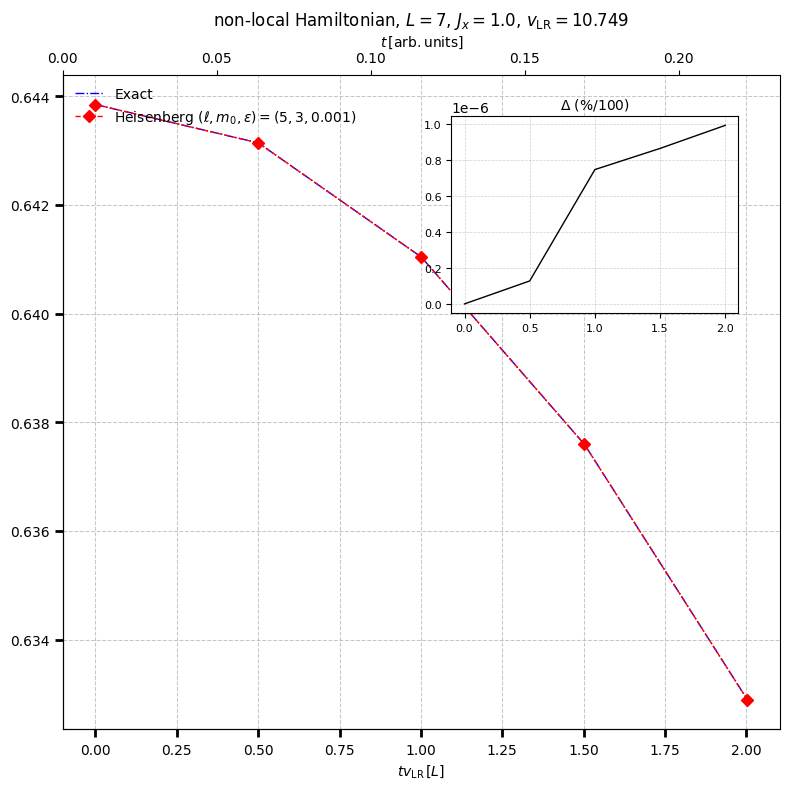

In [14]:
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

# Création de la figure et des axes principaux
fig, ax = plt.subplots(figsize=(8, 8))

n = 1
m = 5

# --- Courbe principale: observable exact + simulation ---
ax.plot(timespan[:m]*vLR, evs_obs_ex.expect[0][:m],
        label='Exact', color="blue", linestyle='dashdot', linewidth=1)

l = simulations[1]["parms"]["chosen_depth"]
m0 = simulations[1]["parms"]["m0"]
eps = simulations[1]["parms"]["eps"]

label_sim1 = fr'Heisenberg $(\ell, m_0, \epsilon) = ({l}, {m0}, {eps})$'
ax.plot(timespan[:m]*vLR, simulations[1]["evs"][:m],
        label=label_sim1, color='red', linestyle='--', marker='D', linewidth=1)

# --- Inset: Delta courbe ---
weigthed_fidelity = np.array([abs(evs_obs_ex.expect[0][i] - simulations[1]["evs"][i])/abs(evs_obs_ex.expect[0][i])
                             for i in range(0, m)])
inset_ax = inset_axes(ax, width="40%", height="30%", loc='upper right', borderpad=3)
inset_ax.plot(timespan[:m]*vLR,weigthed_fidelity,
              color="black", linestyle='solid', linewidth=1)
inset_ax.set_title(r'$\Delta\ (\%/100)$', fontsize=10)

inset_ax.tick_params(labelsize=8)
inset_ax.grid(True, linestyle='--', linewidth=0.5, alpha=0.6)

# --- Style global ---
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.tick_params(direction='out', length=6, width=2, which='major', grid_alpha=0.6)
ax.grid(True, which='major', linestyle='--', linewidth=0.75, alpha=0.7)
ax.legend(frameon=False, loc='upper left')

# Axe secondaire en haut
ax1 = ax.twiny()
ax1.set_xlim(timespan[0], timespan[m])
ax.set_xlabel(r'$t v_{\rm LR} \, [L]$')
ax1.set_xlabel(r'$t \, [{\rm arb. units}]$')

# Titre
plt.title(r'non-local Hamiltonian, $L={}$, $J_x={}$, $v_{{\rm LR}}={}$'.format(
    params['size'], 
    round(params['Jx'], 3), 
    round(vLR, 3)
))

plt.tight_layout()


In [ ]:
timespan

In [21]:
(0.116-0.110)/0.110

0.05454545454545459